In [212]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.set_printoptions(linewidth=150)
pd.set_option('display.max_columns', 500)

# Parse Helpers

In [213]:
log1 = open("model_testbed.log","r").read()
log2 = open("logs/model_testbed.log","r").read()
log = log1+log2
outs = log.split("NEW MODEL ")[1:]


def line_format(line,add_quotes=True):
    if ("INFO" not in line or 'cell:' in line) and "[" in line and "]" in line:
        if "," not in line:
            if "." in line:
                line = re.sub('(?<=\d)\.+',",",line)
            else:
                line = re.sub('(?<=\d)\s+',",",line)
    if "torch.utils.data" in line:
        line = line.replace("<","'").replace(">","'")
            
            
    line = line.replace("\n","").replace(" ","").replace("array","np.array").replace("\e[1m","").replace("\e[21mN","")
    if add_quotes:
        if ":" in line:
            name,val = line.split(":",1)
            if name=='prefix':
                return '"{}":"{}"'.format(name.strip(),val)
            else:
                return '"{}":{}'.format(name.strip(),val)
    return line


def general_stats(line,current,start_cond,end_cond,stats_str):
    if start_cond in line:
        current = start_cond
        stats_str = line_format(line.split("stats:")[-1],False)
    elif current == start_cond:
        if end_cond in line:
            current = ''
            return True,"{}".format(stats_str),current

        else:
            stats_str += '{}'.format(line_format(line,False))
    return False,stats_str,current
            
def specific_stats(line,current,start_cond,end_cond,stats_str=""):
    #print(current,[(x,line,x in line) for x in end_cond])
    if start_cond in line:
        current = start_cond
        stats_str = ""
    
    elif current == start_cond:
        if any([x in line for x in end_cond]):
            current = ''
            return True,"{{{}}}".format(stats_str.rsplit(",",1)[0]),current
        elif line[-1]==",":
            #print("pre add ",stats_str)
            stats_str += '{}'.format(line_format(line.split("run:")[-1]))
            #print("post add",stats_str)
        else:
            #print("pre add ",stats_str)
            stats_str += '{}, '.format(line_format(line.split("run:")[-1]))
            #print("post add",stats_str)
    return False,stats_str,current

# Parser

In [214]:
runs = []
for i,out in enumerate(outs):
    print(i,end="\r")
    curve = []
    predictions = []
    current = None
    time_taken = None
    max_val = None
    early_terminate=False
    stats_str = ""
    epoch_time = None
    run_date = None
    
    general_model_stats,general_run_stats,specific_model_stats,specific_run_stats = {},{},{},{}
    #print("--LOOP ENTER--")
    for line in out.split('\n'):
        #print(line)
        if line=="" or ('Loss' in line and 'Corrects' not in line and 'Epoch: 0' not in line):
            pass
        else:
            
            finished,stats_str,current = general_stats(line,current,'Model stats:','Run stats:',stats_str)
            if finished:
                exec("general_model_stats={}".format(stats_str))
                stats_str = ""
                finished = False
                
            finished,stats_str,current = general_stats(line,current,'Run stats:','=====',stats_str)
            if finished:
                exec("general_run_stats={}".format(stats_str))
                stats_str = ""
                finished = False
            
            finished,stats_str,current = specific_stats(line,current,'-- Model stats',[' Run stats '],stats_str)
            if finished:
                exec("specific_model_stats={}".format(stats_str))
                stats_str = ""
                finished = False
            
            if not specific_run_stats:
                finished,stats_str,current = specific_stats(line,current,' Run stats ',['====',"Per epoch","Run finished","Train Epoch: 0"],stats_str)
                if finished:
                    #print("RUN FINISHED")
                    exec("specific_run_stats={}".format(stats_str))
                    stats_str = ""
                    finished = False
            
            if "Corrects" in line:
                curve.append(int(line.split(":")[-1].split("/")[0]))
            if "Prediction" in line:
                if "[[" in line:
                    predictions.append(float(line.split("[[")[-1].split("]]")[0]))
                elif "," in line:
                    predictions.append(float(line.split(":")[-1].split(",")[0]))
                else:
                    predictions.append(float(line.split(":")[-1]))
            if "Time taken" in line:
                time_taken = line.split(":")[-1]
            if "terminated" in line.lower():
                early_terminate=True
            if 'Run started' in line:
                run_date = line.split("at ")[-1]
            if 'Max corrects' in line:
                max_val = int(line.split(":")[-1].split("/")[0])
            if 'Per epoch time' in line:
                epoch_time = line.split(":")[-1].strip()
    #print("--LOOP EXIT--")
    
    stats = {}
    if general_run_stats:
        stats.update(general_run_stats)
    if general_model_stats:
        stats.update(general_model_stats)
    if specific_run_stats:
        stats.update(specific_run_stats)
    if specific_model_stats:
        stats.update(specific_model_stats)
    
    for key in stats.keys():
        new_key = key.strip().replace('matrix','matrices')
        #print(key)
        if key=='cell':
            new_key='cell_matrices'
        if key=='momemtum':
            new_key = 'momentum'
        if new_key!=key:
            stats[new_key] = stats.pop(key)
        
    stats['curve']=curve
    stats['predictions']=predictions
    stats['epoch']=len(curve)
    stats['time_taken']=time_taken
    stats['early_terminate']=early_terminate
    stats['per_epoch_time']=epoch_time
    if not max_val:
        stats['max']=max(curve) if len(curve)>0 else None
    else:
        stats['max']=max_val
    stats['run_date']=run_date
    runs.append(stats)
    
run_stats = pd.DataFrame(runs)
run_stats.to_pickle('run_stats.pkl')
run_stats

,cell_matrices,cell_types,curve,data,drop_path,early_terminate,epoch,epochs,log,lr,lr_schedule,max,momentum,params,per_epoch_time,predictions,prefix,residual_cells,run_date,scale,scales,time_taken,track_progess,track_progress,verbose,weight_decay
0,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[2512, 4414, 4551, 5161, 5186, 5298, 5543, 581...",(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,10,10.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",5813.0,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)","3 min, 15 s",NaN,NaN,True,0.0001
1,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[3840, 3939, 4431]",(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,3,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",4431.0,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)","1 min, 0 s",NaN,NaN,True,0.0001
2,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[2376, 3827, 4112]",(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,3,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",4112.0,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)","1 min, 1 s",NaN,NaN,True,0.0001
3,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[4113, 4653]",(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,2,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",4653.0,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001
4,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]",[],(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,0,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",NaN,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001
5,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]",[],(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,0,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",NaN,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001
6,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]",[],(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,0,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",NaN,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001
7,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]",[],(torch.utils.data.dataloader.DataLoaderobjecta...,NaN,False,0,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",NaN,0.9,9490918.0,None,[],NaN,NaN,None,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001
8,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[3849, 4024, 4326]",NaN,NaN,False,3,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",4326.0,0.9,9490918.0,None,[],NaN,NaN,2018-10-29 13:38:42,2.0,"(1.0, 1.0)","1 min, 1 s",NaN,NaN,True,0.0001
9,"[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [0...","[1, 0]","[3723, 4252]",NaN,NaN,False,2,3.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",4252.0,0.9,9490918.0,None,[],NaN,NaN,2018-10-29 13:39:58,2.0,"(1.0, 1.0)",None,NaN,NaN,True,0.0001


# See all 512 Epoch Runs

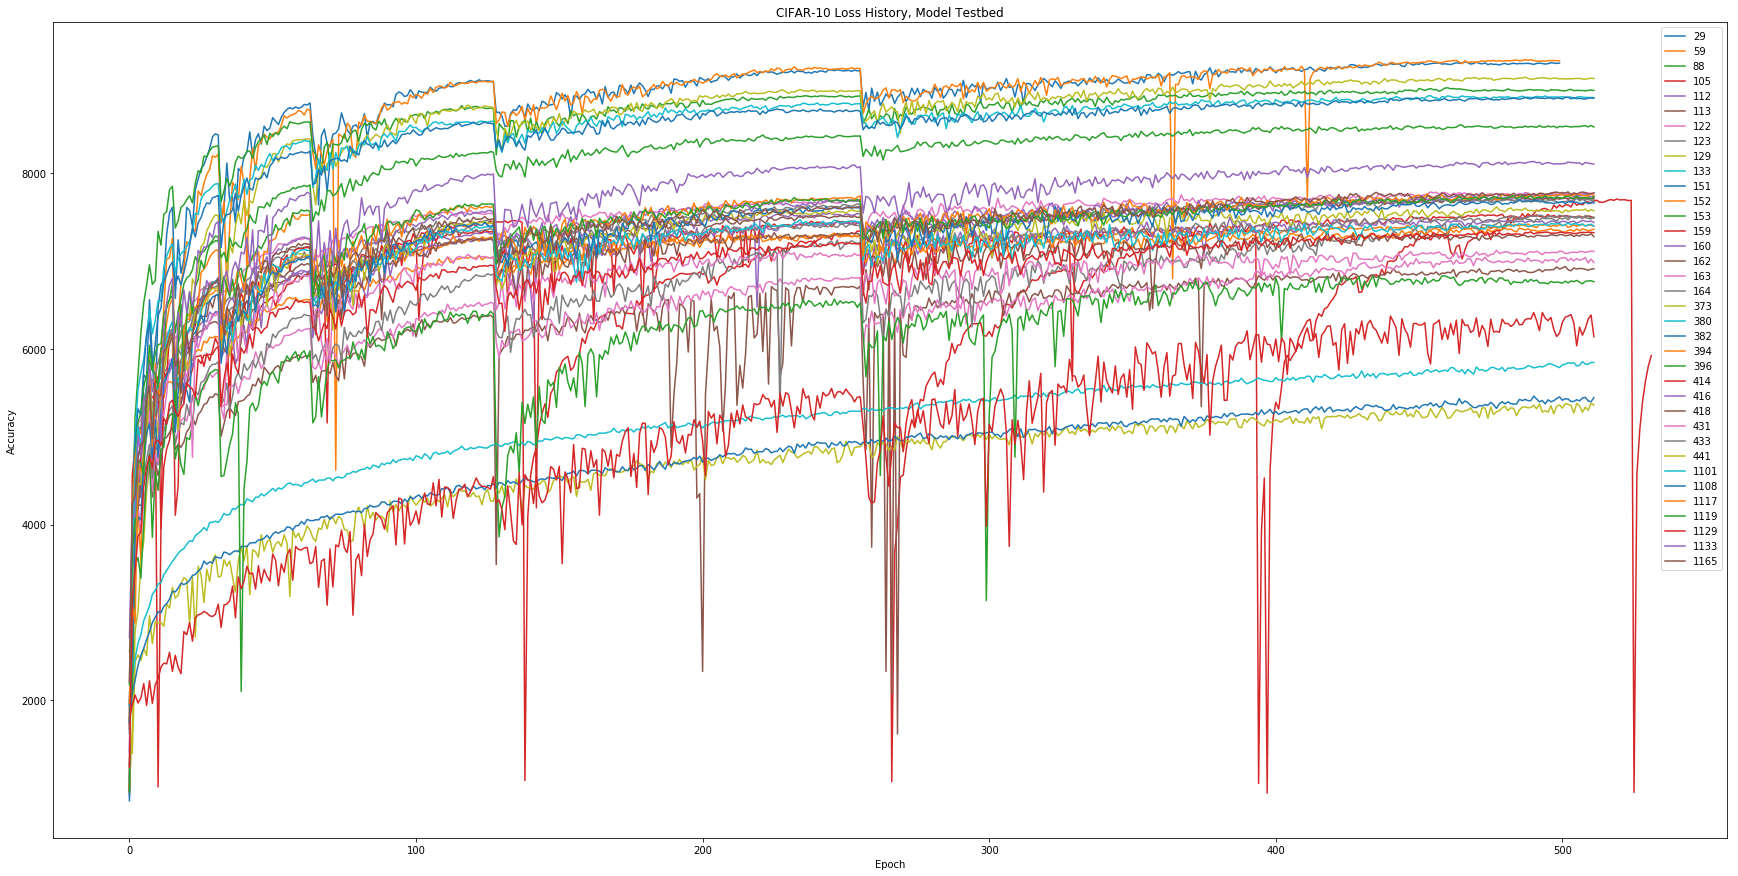

In [215]:
plt.figure(figsize=(30,15))
for i,curve in enumerate(run_stats['curve']):
    if len(curve)>=500:
        plt.plot(curve,label=i)
plt.title("CIFAR-10 Loss History, Model Testbed")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# See Cumulative Maxes of all 512 Epoch Runs

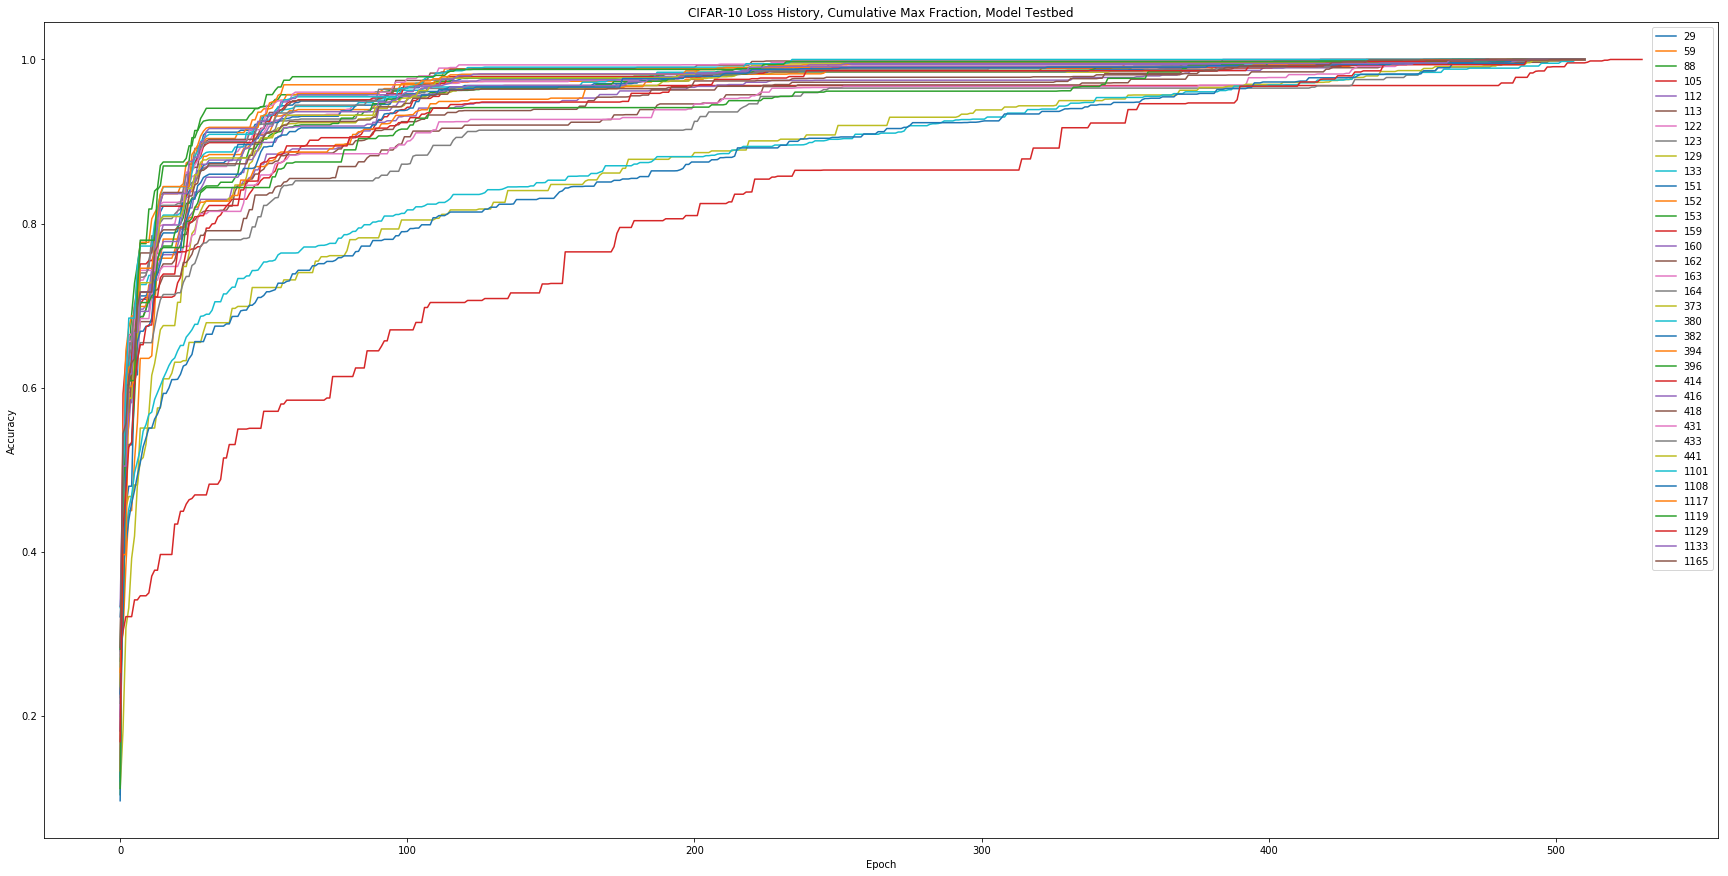

In [216]:
plt.figure(figsize=(30,15))

for i,curve in enumerate(run_stats['curve']):
    if len(curve)>=500:
        cum_max= [max(curve[:i])/max(curve) for i in range(1,len(curve))]
        plt.plot(cum_max,label=i)
plt.title("CIFAR-10 Loss History, Cumulative Max Fraction, Model Testbed")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Macro Train Predictors

In [217]:
import copy
pd.options.mode.chained_assignment = None

predictor_df = copy.copy(run_stats)
losses = predictor_df[predictor_df['epoch']>=500]
losses['curve']=losses['curve'].apply(lambda x: x+[max(x)]*12 if len(x)==500 else x)
losses['curve']=losses['curve'].apply(lambda x: x[:512] if len(x)>512 else x)
losses['reductions']=losses['cell_types'].apply(sum)
losses['parallel']=losses['cell_matrices'].apply(lambda x: len(x) if len(x)<3 else 1)
losses['cells']=losses['cell_types'].apply(len)
losses['nodes']=losses['cell_matrices'].apply(lambda x: len(x[0]) if len(x)<3 else len(x))


losses = losses[losses['reductions']>4]
for i in range(512):
    if i==0:
        losses['max_curve_{}'.format(i)]=losses['curve'].apply(lambda x:x[0])
    else:
        losses['max_curve_{}'.format(i)]=losses['curve'].apply(lambda x: max(x[:i+1]))
    losses['curve_{}'.format(i)]=losses['curve'].apply(lambda x: x[i])
losses.to_pickle('macro_losses.pkl')
losses.iloc[0:10]

,cell_matrices,cell_types,curve,data,drop_path,early_terminate,epoch,epochs,log,lr,lr_schedule,max,momentum,params,per_epoch_time,predictions,prefix,residual_cells,run_date,scale,scales,time_taken,track_progess,track_progress,verbose,weight_decay,reductions,parallel,cells,nodes,max_curve_0,curve_0,max_curve_1,curve_1,max_curve_2,curve_2,max_curve_3,curve_3,max_curve_4,curve_4,max_curve_5,curve_5,max_curve_6,curve_6,max_curve_7,curve_7,max_curve_8,curve_8,max_curve_9,curve_9,max_curve_10,curve_10,max_curve_11,curve_11,max_curve_12,curve_12,max_curve_13,curve_13,max_curve_14,curve_14,max_curve_15,curve_15,max_curve_16,curve_16,max_curve_17,curve_17,max_curve_18,curve_18,max_curve_19,curve_19,max_curve_20,curve_20,max_curve_21,curve_21,max_curve_22,curve_22,max_curve_23,curve_23,max_curve_24,curve_24,max_curve_25,curve_25,max_curve_26,curve_26,max_curve_27,curve_27,max_curve_28,curve_28,max_curve_29,curve_29,max_curve_30,curve_30,max_curve_31,curve_31,max_curve_32,curve_32,max_curve_33,curve_33,max_curve_34,curve_34,max_curve_35,curve_35,max_curve_36,curve_36,max_curve_37,curve_37,max_curve_38,curve_38,max_curve_39,curve_39,max_curve_40,curve_40,max_curve_41,curve_41,max_curve_42,curve_42,max_curve_43,curve_43,max_curve_44,curve_44,max_curve_45,curve_45,max_curve_46,curve_46,max_curve_47,curve_47,max_curve_48,curve_48,max_curve_49,curve_49,max_curve_50,curve_50,max_curve_51,curve_51,max_curve_52,curve_52,max_curve_53,curve_53,max_curve_54,curve_54,max_curve_55,curve_55,max_curve_56,curve_56,max_curve_57,curve_57,max_curve_58,curve_58,max_curve_59,curve_59,max_curve_60,curve_60,max_curve_61,curve_61,max_curve_62,curve_62,max_curve_63,curve_63,max_curve_64,curve_64,max_curve_65,curve_65,max_curve_66,curve_66,max_curve_67,curve_67,max_curve_68,curve_68,max_curve_69,curve_69,max_curve_70,curve_70,max_curve_71,curve_71,max_curve_72,curve_72,max_curve_73,curve_73,max_curve_74,curve_74,max_curve_75,curve_75,max_curve_76,curve_76,max_curve_77,curve_77,max_curve_78,curve_78,max_curve_79,curve_79,max_curve_80,curve_80,max_curve_81,curve_81,max_curve_82,curve_82,max_curve_83,curve_83,max_curve_84,curve_84,max_curve_85,curve_85,max_curve_86,curve_86,max_curve_87,curve_87,max_curve_88,curve_88,max_curve_89,curve_89,max_curve_90,curve_90,max_curve_91,curve_91,max_curve_92,curve_92,max_curve_93,curve_93,max_curve_94,curve_94,max_curve_95,curve_95,max_curve_96,curve_96,max_curve_97,curve_97,max_curve_98,curve_98,max_curve_99,curve_99,max_curve_100,curve_100,max_curve_101,curve_101,max_curve_102,curve_102,max_curve_103,curve_103,max_curve_104,curve_104,max_curve_105,curve_105,max_curve_106,curve_106,max_curve_107,curve_107,max_curve_108,curve_108,max_curve_109,curve_109,...,max_curve_387,curve_387,max_curve_388,curve_388,max_curve_389,curve_389,max_curve_390,curve_390,max_curve_391,curve_391,max_curve_392,curve_392,max_curve_393,curve_393,max_curve_394,curve_394,max_curve_395,curve_395,max_curve_396,curve_396,max_curve_397,curve_397,max_curve_398,curve_398,max_curve_399,curve_399,max_curve_400,curve_400,max_curve_401,curve_401,max_curve_402,curve_402,max_curve_403,curve_403,max_curve_404,curve_404,max_curve_405,curve_405,max_curve_406,curve_406,max_curve_407,curve_407,max_curve_408,curve_408,max_curve_409,curve_409,max_curve_410,curve_410,max_curve_411,curve_411,max_curve_412,curve_412,max_curve_413,curve_413,max_curve_414,curve_414,max_curve_415,curve_415,max_curve_416,curve_416,max_curve_417,curve_417,max_curve_418,curve_418,max_curve_419,curve_419,max_curve_420,curve_420,max_curve_421,curve_421,max_curve_422,curve_422,max_curve_423,curve_423,max_curve_424,curve_424,max_curve_425,curve_425,max_curve_426,curve_426,max_curve_427,curve_427,max_curve_428,curve_428,max_curve_429,curve_429,max_curve_430,curve_430,max_curve_431,curve_431,max_curve_432,curve_432,max_curve_433,curve_433,max_curve_434,curve_434,max_curve_435,curve_435,max_curve_436,curve_436,max_curve_437,curve_437,max_curve_438,curve_438,max_curve_439,curve_439,max_curve_440,curve_440,m

24 8



==0==============================


,max_curve_0,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
59,-1233.041721,586.888329,-1.303846e-11,-914.684332,-587.898021,437.791026,9823.661571,8112,9298.0,11.86
153,-460.277618,548.875328,-1.303846e-11,-1829.368663,-407.006323,437.791026,9823.661571,8113,8551.0,4.38
152,-476.215878,58.192673,-1.303846e-11,-914.684332,-407.006323,364.825855,9823.661571,8448,7425.0,-10.23
122,-461.726551,226.242228,-1.303846e-11,-914.684332,-407.006323,364.825855,9823.661571,8631,7789.0,-8.42
441,-866.461750,74.868288,-1.303846e-11,-1829.368663,-587.898021,364.825855,9823.661571,6979,7620.0,6.41
373,-866.461750,30.399184,-1.303846e-11,-1829.368663,-587.898021,291.860684,9823.661571,6862,5381.0,-14.81
164,-805.606577,8.137749,-1.303846e-11,-1829.368663,-407.006323,364.825855,9823.661571,7154,7504.0,3.50
396,-920.555237,79.243748,-1.303846e-11,-1829.368663,-587.898021,291.860684,9823.661571,6856,6833.0,-0.23


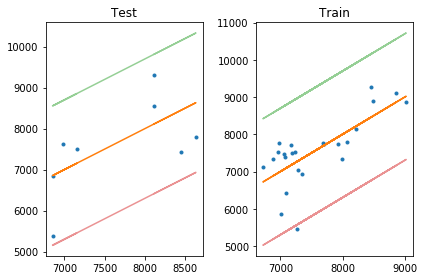

	Intercept: 9823.66157090506
	Coefficients: 
	 max_curve_0: -0.4830 params: 0.0000 reductions: -0.0000 parallel: -914.6843 cells: -45.2229 nodes: 72.9652
	PearsonR: 0.729,0.000
	95%: ±1698.60



==50==============================


,max_curve_50,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
59,5078.093736,214.192139,3.552714e-13,-201.283081,-290.600727,415.801716,3686.352144,8902,9298.0,3.96
153,4641.093955,200.318825,3.552714e-13,-402.566162,-201.185119,415.801716,3686.352144,8339,8551.0,2.12
152,3880.702315,21.238134,3.552714e-13,-201.283081,-201.185119,346.501430,3686.352144,7532,7425.0,-1.07
122,4264.805286,82.569893,3.552714e-13,-201.283081,-201.185119,346.501430,3686.352144,7977,7789.0,-1.88
441,4142.781964,27.324106,3.552714e-13,-402.566162,-290.600727,346.501430,3686.352144,7509,7620.0,1.11
373,2335.273930,11.094558,3.552714e-13,-402.566162,-290.600727,277.201144,3686.352144,5616,5381.0,-2.35
164,3708.186583,2.969972,3.552714e-13,-402.566162,-201.185119,346.501430,3686.352144,7140,7504.0,3.64
396,3465.943239,28.920984,3.552714e-13,-402.566162,-290.600727,277.201144,3686.352144,6765,6833.0,0.68


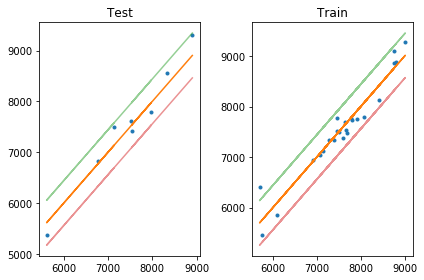

	Intercept: 3686.352144306979
	Coefficients: 
	 max_curve_50: 0.6011 params: 0.0000 reductions: 0.0000 parallel: -201.2831 cells: -22.3539 nodes: 69.3003
	PearsonR: 0.966,0.000
	95%: ±441.13



==100==============================


,max_curve_100,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
59,5696.721815,188.980348,-2.842171e-13,-182.968328,-215.717365,419.360894,3100.011875,9006,9298.0,2.92
153,5228.182448,176.740012,-2.842171e-13,-365.936657,-149.342791,419.360894,3100.011875,8409,8551.0,1.42
152,4430.001313,18.738269,-2.842171e-13,-182.968328,-149.342791,349.467411,3100.011875,7565,7425.0,-1.40
122,4820.450785,72.850886,-2.842171e-13,-182.968328,-149.342791,349.467411,3100.011875,8010,7789.0,-2.21
441,4645.708644,24.107883,-2.842171e-13,-365.936657,-215.717365,349.467411,3100.011875,7537,7620.0,0.83
373,2770.271013,9.788657,-2.842171e-13,-365.936657,-215.717365,279.573929,3100.011875,5577,5381.0,-1.96
164,4189.970899,2.620387,-2.842171e-13,-365.936657,-149.342791,349.467411,3100.011875,7126,7504.0,3.78
396,4002.427136,25.516798,-2.842171e-13,-365.936657,-215.717365,279.573929,3100.011875,6825,6833.0,0.08


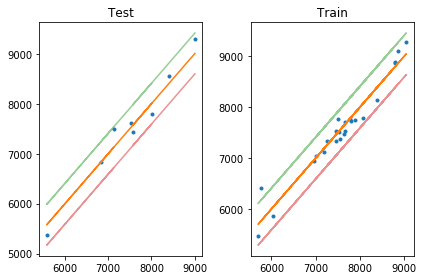

	Intercept: 3100.011875027978
	Coefficients: 
	 max_curve_100: 0.6401 params: 0.0000 reductions: -0.0000 parallel: -182.9683 cells: -16.5936 nodes: 69.8935
	PearsonR: 0.974,0.000
	95%: ±408.50



==150==============================


,max_curve_150,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
59,6081.446772,187.840942,3.552714e-13,-172.195865,-302.920974,358.266920,2893.874441,9046,9298.0,2.52
153,5542.575894,175.674406,3.552714e-13,-344.391730,-209.714521,358.266920,2893.874441,8416,8551.0,1.35
152,4753.754934,18.625292,3.552714e-13,-172.195865,-209.714521,298.555766,2893.874441,7582,7425.0,-1.57
122,5092.396982,72.411652,3.552714e-13,-172.195865,-209.714521,298.555766,2893.874441,7975,7789.0,-1.86
441,5005.720744,23.962531,3.552714e-13,-344.391730,-302.920974,298.555766,2893.874441,7574,7620.0,0.46
373,3064.576149,9.729639,3.552714e-13,-344.391730,-302.920974,238.844613,2893.874441,5559,5381.0,-1.78
164,4607.278811,2.604588,3.552714e-13,-344.391730,-209.714521,298.555766,2893.874441,7248,7504.0,2.56
396,4321.717560,25.362952,3.552714e-13,-344.391730,-302.920974,238.844613,2893.874441,6832,6833.0,0.01


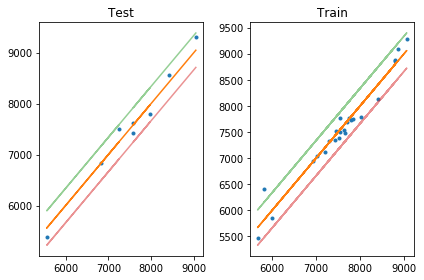

	Intercept: 2893.874440997123
	Coefficients: 
	 max_curve_150: 0.6719 params: 0.0000 reductions: 0.0000 parallel: -172.1959 cells: -23.3016 nodes: 59.7112
	PearsonR: 0.978,0.000
	95%: ±337.46



==200==============================


,max_curve_200,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
59,6824.682614,135.999968,0.0,-120.523334,-155.121633,276.189561,2114.29606,9075,9298.0,2.23
153,6310.932120,127.191194,0.0,-241.046668,-107.391900,276.189561,2114.29606,8480,8551.0,0.71
152,5467.719378,13.485021,0.0,-120.523334,-107.391900,230.157968,2114.29606,7597,7425.0,-1.72
122,5747.536631,52.427241,0.0,-120.523334,-107.391900,230.157968,2114.29606,7916,7789.0,-1.27
441,5627.937321,17.349271,0.0,-241.046668,-155.121633,230.157968,2114.29606,7593,7620.0,0.27
373,3587.979287,7.044420,0.0,-241.046668,-155.121633,184.126374,2114.29606,5497,5381.0,-1.16
164,5218.742199,1.885765,0.0,-241.046668,-107.391900,230.157968,2114.29606,7216,7504.0,2.88
396,4841.139348,18.363199,0.0,-241.046668,-155.121633,184.126374,2114.29606,6761,6833.0,0.72


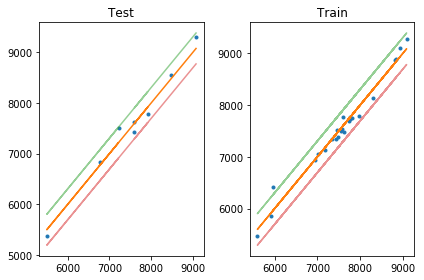

	Intercept: 2114.2960595972027
	Coefficients: 
	 max_curve_200: 0.7522 params: 0.0000 reductions: 0.0000 parallel: -120.5233 cells: -11.9324 nodes: 46.0316
	PearsonR: 0.988,0.000
	95%: ±305.15



==250==============================


,max_curve_250,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
59,7389.983501,117.870027,2.842171e-13,-85.056434,-67.140785,238.961066,1576.253886,9170,9298.0,1.28
153,6766.867150,110.235537,2.842171e-13,-170.112867,-46.482082,238.961066,1576.253886,8475,8551.0,0.76
152,5871.087272,11.687355,2.842171e-13,-85.056434,-46.482082,199.134222,1576.253886,7526,7425.0,-1.01
122,6167.007393,45.438248,2.842171e-13,-85.056434,-46.482082,199.134222,1576.253886,7856,7789.0,-0.67
441,6077.990771,15.036467,2.842171e-13,-170.112867,-67.140785,199.134222,1576.253886,7631,7620.0,-0.11
373,3968.056252,6.105340,2.842171e-13,-170.112867,-67.140785,159.307377,1576.253886,5472,5381.0,-0.91
164,5807.733100,1.634377,2.842171e-13,-170.112867,-46.482082,199.134222,1576.253886,7368,7504.0,1.36
396,5268.019709,15.915230,2.842171e-13,-170.112867,-67.140785,159.307377,1576.253886,6782,6833.0,0.51


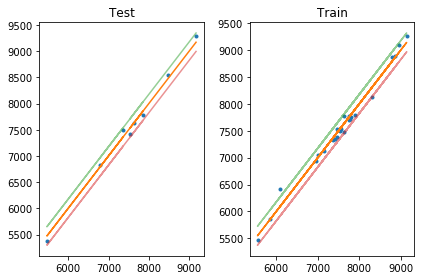

	Intercept: 1576.2538855525054
	Coefficients: 
	 max_curve_250: 0.8020 params: 0.0000 reductions: 0.0000 parallel: -85.0564 cells: -5.1647 nodes: 39.8268
	PearsonR: 0.993,0.000
	95%: ±175.96



==300==============================


,max_curve_300,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
59,7619.013493,87.356250,1.421085e-13,-80.811836,-91.755613,248.152135,1400.65765,9182,9298.0,1.16
153,6976.585551,81.698149,1.421085e-13,-161.623672,-63.523116,248.152135,1400.65765,8481,8551.0,0.70
152,6053.043709,8.661773,1.421085e-13,-80.811836,-63.523116,206.793446,1400.65765,7524,7425.0,-0.99
122,6358.134971,33.675355,1.421085e-13,-80.811836,-63.523116,206.793446,1400.65765,7854,7789.0,-0.65
441,6271.320385,11.143880,1.421085e-13,-161.623672,-91.755613,206.793446,1400.65765,7636,7620.0,-0.16
373,4175.368219,4.524811,1.421085e-13,-161.623672,-91.755613,165.434757,1400.65765,5492,5381.0,-1.11
164,5987.726068,1.211275,1.421085e-13,-161.623672,-63.523116,206.793446,1400.65765,7371,7504.0,1.33
396,5431.285907,11.795151,1.421085e-13,-161.623672,-91.755613,165.434757,1400.65765,6755,6833.0,0.78


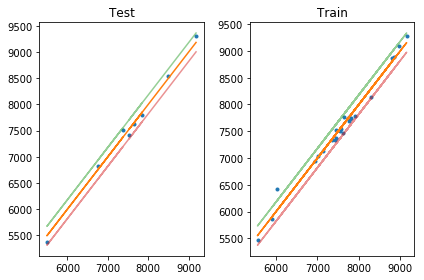

	Intercept: 1400.6576496845864
	Coefficients: 
	 max_curve_300: 0.8268 params: 0.0000 reductions: 0.0000 parallel: -80.8118 cells: -7.0581 nodes: 41.3587
	PearsonR: 0.992,0.000
	95%: ±179.96



==350==============================


,max_curve_350,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
59,8235.177717,51.251349,-3.552714e-14,-54.887259,-122.976823,150.732628,960.925101,9220,9298.0,0.78
153,7564.030841,47.931778,-3.552714e-14,-109.774517,-85.137801,150.732628,960.925101,8528,8551.0,0.23
152,6597.972554,5.081807,-3.552714e-14,-54.887259,-85.137801,125.610524,960.925101,7549,7425.0,-1.24
122,6897.352319,19.757113,-3.552714e-14,-54.887259,-85.137801,125.610524,960.925101,7863,7789.0,-0.74
441,6778.494084,6.538042,-3.552714e-14,-109.774517,-122.976823,125.610524,960.925101,7638,7620.0,-0.18
373,4577.382558,2.654677,-3.552714e-14,-109.774517,-122.976823,100.488419,960.925101,5408,5381.0,-0.27
164,6471.964952,0.710647,-3.552714e-14,-109.774517,-85.137801,125.610524,960.925101,7364,7504.0,1.40
396,5966.147199,6.920139,-3.552714e-14,-109.774517,-122.976823,100.488419,960.925101,6801,6833.0,0.32


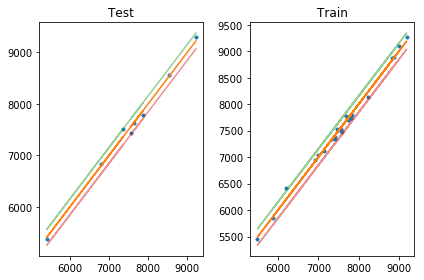

	Intercept: 960.9251010199441
	Coefficients: 
	 max_curve_350: 0.8937 params: 0.0000 reductions: -0.0000 parallel: -54.8873 cells: -9.4598 nodes: 25.1221
	PearsonR: 0.997,0.000
	95%: ±153.65



==400==============================


,max_curve_400,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
59,8723.521122,26.223521,3.552714e-14,-20.892633,-69.353087,53.226445,509.883043,9222,9298.0,0.76
153,8068.428706,24.525012,3.552714e-14,-41.785265,-48.013676,53.226445,509.883043,8566,8551.0,-0.15
152,7000.590201,2.600183,3.552714e-14,-20.892633,-48.013676,44.355371,509.883043,7488,7425.0,-0.63
122,7341.389724,10.109023,3.552714e-14,-20.892633,-48.013676,44.355371,509.883043,7836,7789.0,-0.47
441,7180.456616,3.345287,3.552714e-14,-41.785265,-69.353087,44.355371,509.883043,7626,7620.0,-0.06
373,4939.699752,1.358305,3.552714e-14,-41.785265,-69.353087,35.484297,509.883043,5375,5381.0,0.06
164,6855.750404,0.363613,3.552714e-14,-41.785265,-48.013676,44.355371,509.883043,7320,7504.0,1.84
396,6444.897645,3.540793,3.552714e-14,-41.785265,-69.353087,35.484297,509.883043,6882,6833.0,-0.49


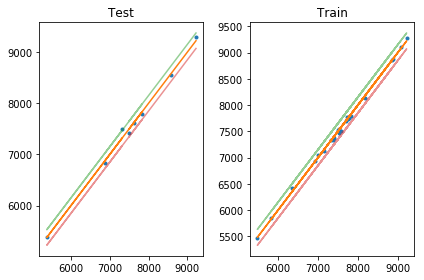

	Intercept: 509.88304335785415
	Coefficients: 
	 max_curve_400: 0.9467 params: 0.0000 reductions: 0.0000 parallel: -20.8926 cells: -5.3349 nodes: 8.8711
	PearsonR: 0.999,0.000
	95%: ±151.21



==450==============================


,max_curve_450,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
59,9017.143378,33.055312,0.0,-0.039688,33.018889,-11.041840,197.948907,9270,9298.0,0.28
153,8309.897372,30.914305,0.0,-0.079377,22.859231,-11.041840,197.948907,8550,8551.0,0.01
152,7208.655997,3.277586,0.0,-0.039688,22.859231,-9.201533,197.948907,7423,7425.0,0.02
122,7558.874102,12.742641,0.0,-0.039688,22.859231,-9.201533,197.948907,7783,7789.0,0.06
441,7389.602018,4.216807,0.0,-0.079377,33.018889,-9.201533,197.948907,7615,7620.0,0.05
373,5163.771394,1.712173,0.0,-0.079377,33.018889,-7.361227,197.948907,5389,5381.0,-0.08
164,7160.987421,0.458342,0.0,-0.079377,22.859231,-9.201533,197.948907,7372,7504.0,1.32
396,6646.361372,4.463246,0.0,-0.079377,33.018889,-7.361227,197.948907,6874,6833.0,-0.41


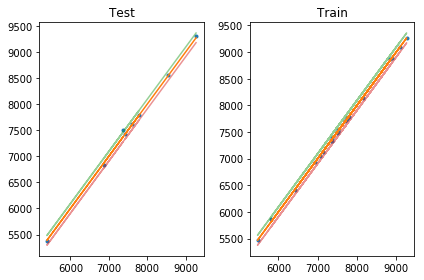

	Intercept: 197.94890747174395
	Coefficients: 
	 max_curve_450: 0.9728 params: 0.0000 reductions: 0.0000 parallel: -0.0397 cells: 2.5399 nodes: -1.8403
	PearsonR: 1.000,0.000
	95%: ±92.77



==500==============================


,max_curve_500,params,reductions,parallel,cells,nodes,intercept,pred,_score,%pts error
59,9268.178390,0.715978,0.0,-1.737132,-0.765907,3.167278,26.714031,9296,9298.0,0.02
153,8523.574254,0.669604,0.0,-3.474264,-0.530244,3.167278,26.714031,8550,8551.0,0.01
152,7401.185690,0.070992,0.0,-1.737132,-0.530244,2.639398,26.714031,7428,7425.0,-0.03
122,7764.018227,0.276005,0.0,-1.737132,-0.530244,2.639398,26.714031,7791,7789.0,-0.02
441,7595.560263,0.091336,0.0,-3.474264,-0.765907,2.639398,26.714031,7620,7620.0,0.00
373,5355.767099,0.037086,0.0,-3.474264,-0.765907,2.111519,26.714031,5380,5381.0,0.01
164,7469.964385,0.009928,0.0,-3.474264,-0.530244,2.639398,26.714031,7495,7504.0,0.09
396,6811.084420,0.096674,0.0,-3.474264,-0.765907,2.111519,26.714031,6835,6833.0,-0.02


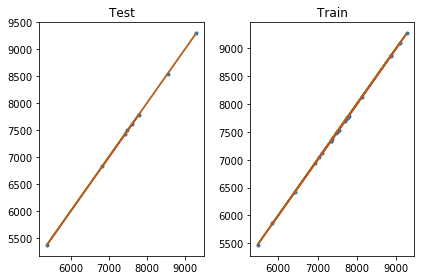

	Intercept: 26.714031251924098
	Coefficients: 
	 max_curve_500: 0.9968 params: 0.0000 reductions: 0.0000 parallel: -1.7371 cells: -0.0589 nodes: 0.5279
	PearsonR: 1.000,0.000
	95%: ±7.05


In [218]:
from sklearn import linear_model
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
import pickle as pkl

train,test = train_test_split(losses,test_size=.25)
print(len(train),len(test))
funcs = {}
for i in range(512):
    regr = linear_model.LinearRegression()

    column_selector=['max_curve_{}'.format(i),'params','reductions','parallel','cells','nodes']
    train_X = train[column_selector]
    train_Y = train['max']
    
    test_X = test[column_selector]
    test_Y = test['max']
    
    regr = linear_model.LinearRegression()
    regr.fit(train_X,train_Y)
    x_func = regr.intercept_+np.dot(train_X,regr.coef_)
    pred = regr.intercept_+np.dot(test_X,regr.coef_)
    c95 = np.std(test_Y.values-pred)*1.96
    funcs[i]={'b':regr.intercept_,'m':regr.coef_,'95':c95,'coef_names':column_selector}
    
    if not i%50:
        print("\n\n\n=={}==============================".format(i))
        xy_df = pd.DataFrame(test_X*regr.coef_)
        xy_df['intercept']=regr.intercept_
        xy_df['pred']=xy_df.apply(lambda x: int(sum(x)),1)
        xy_df['_score']=test_Y
        xy_df['%pts error']=(xy_df['_score']-xy_df['pred'])/100
        display(xy_df)
        #display(test)
        
        plt.subplot(121)
        plt.plot(pred,test_Y,".")
        plt.plot(pred,pred)
        plt.plot(pred,pred+c95,alpha=.5)
        plt.plot(pred,pred-c95,alpha=.5)
        plt.title("Test")
        
        plt.subplot(122)
        plt.plot(x_func,train_Y,".")
        plt.plot(x_func,x_func)
        plt.plot(x_func,x_func+c95,alpha=.5)
        plt.plot(x_func,x_func-c95,alpha=.5)
        plt.title("Train")
        plt.tight_layout()
        
        plt.show()
        print('\tIntercept:', regr.intercept_)
        print('\tCoefficients: \n\t', *["{}: {:.4f}".format(list(train_X)[i],x) for (i,x) in enumerate(regr.coef_)])
        print("\tPearsonR: {:.3f},{:.3f}".format(*pearsonr(x_func,train_Y)))
        print("\t95%: ±{:.2f}".format(c95))
        
pkl.dump(funcs,open('macro_loss_predictors.pkl',"wb"))

# Check Macro Predictions

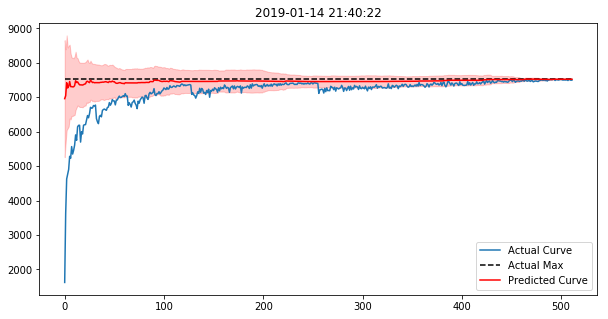

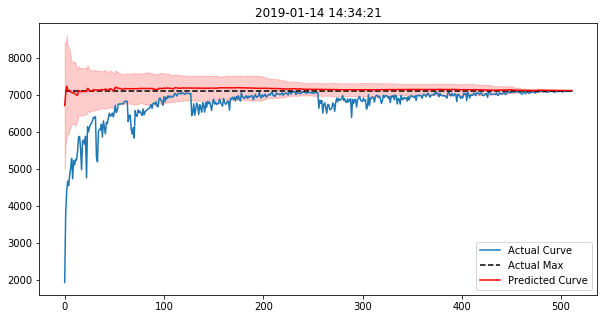

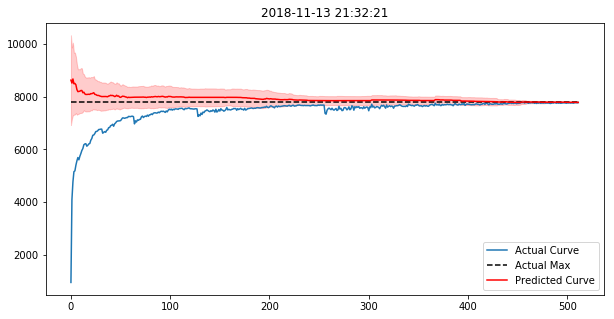

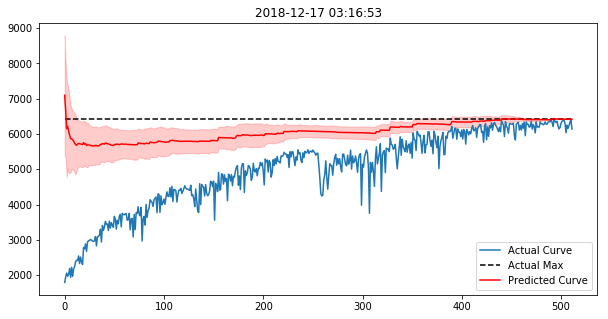

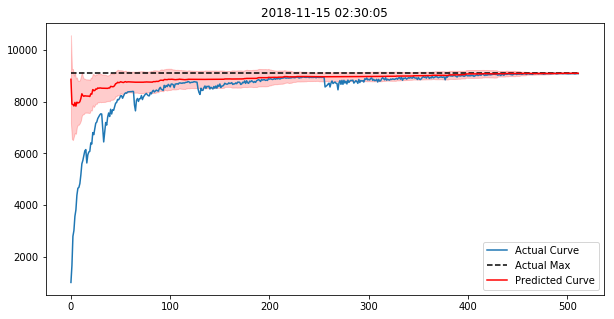

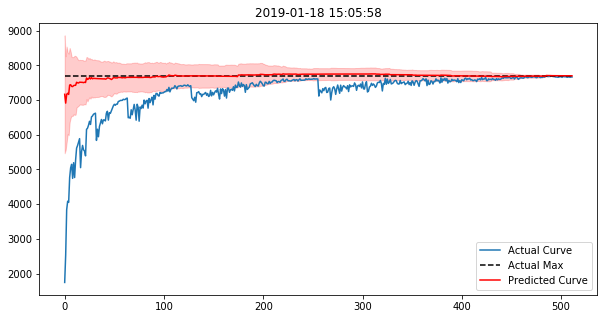

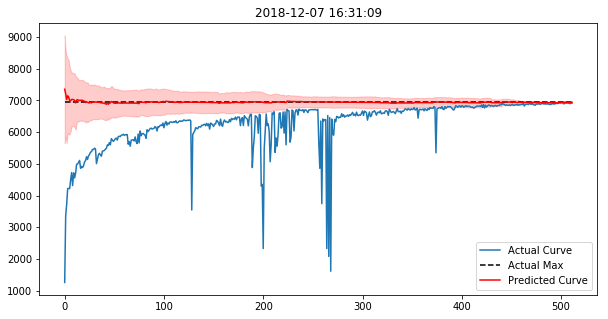

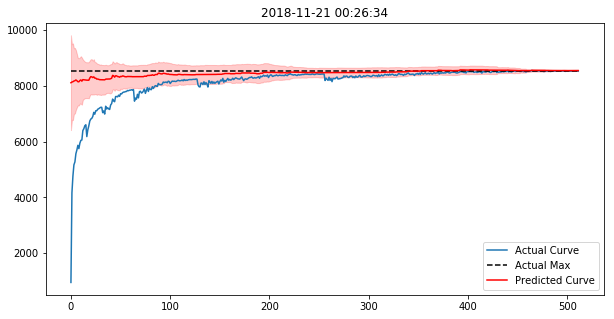

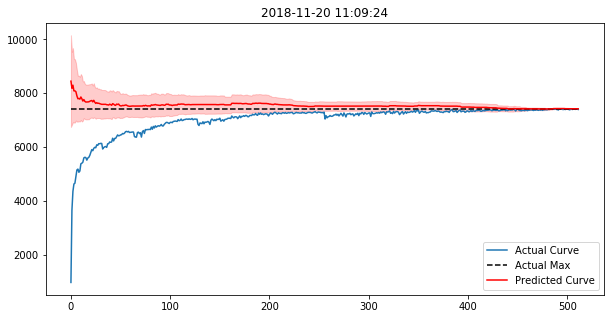

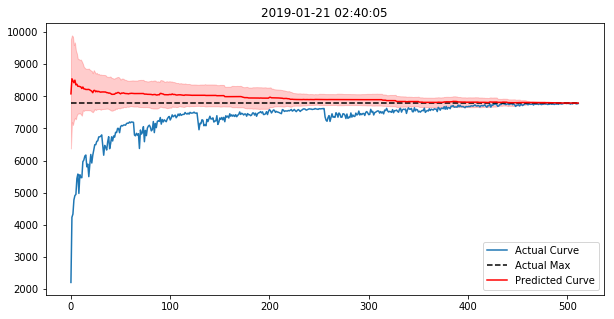

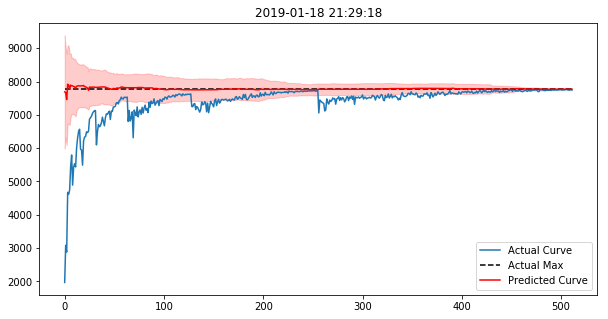

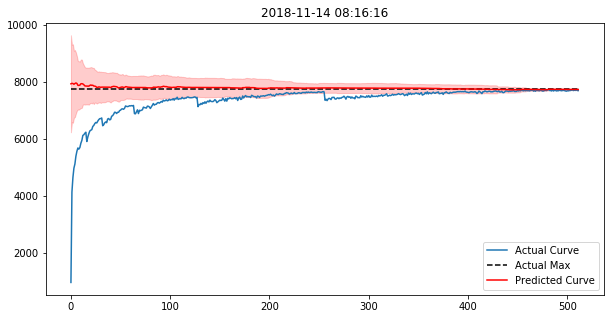

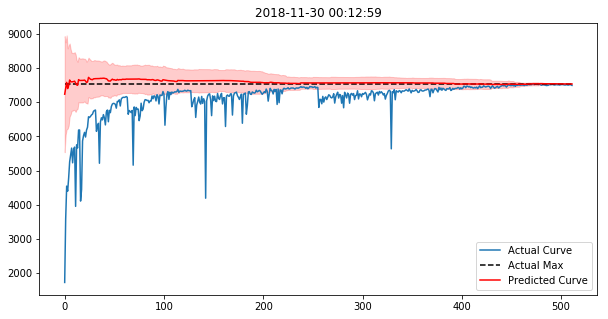

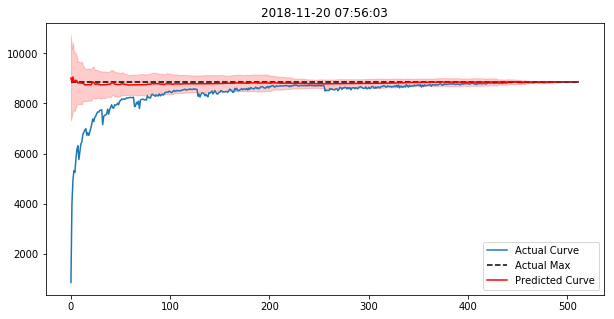

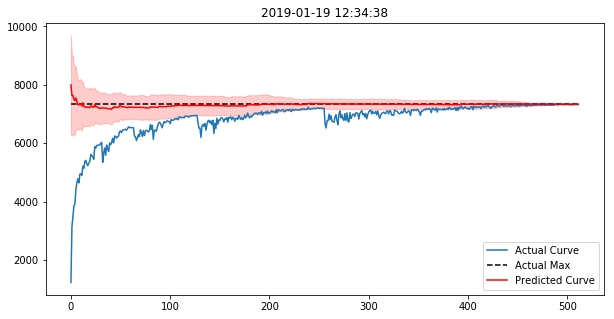

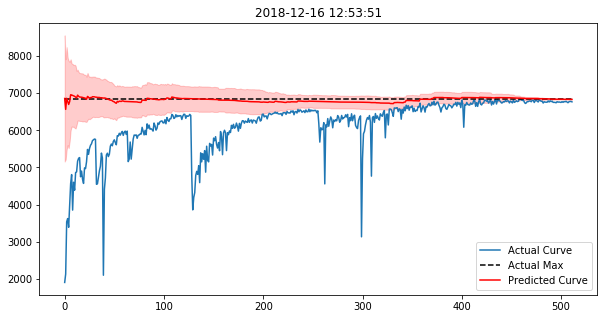

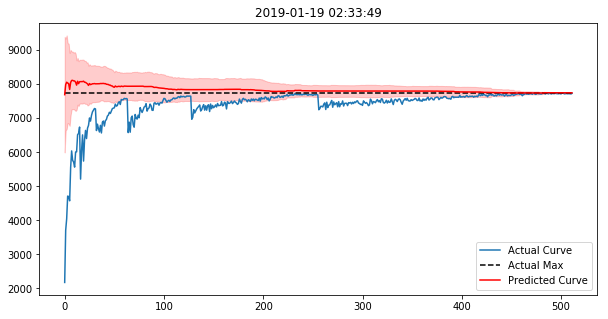

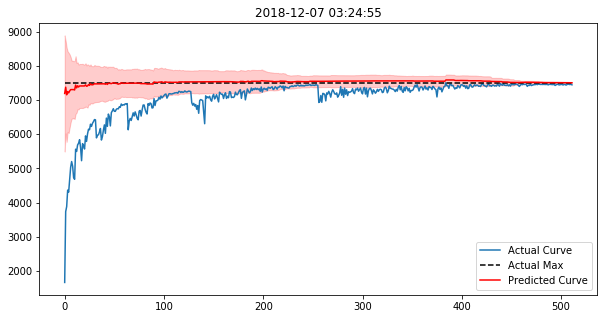

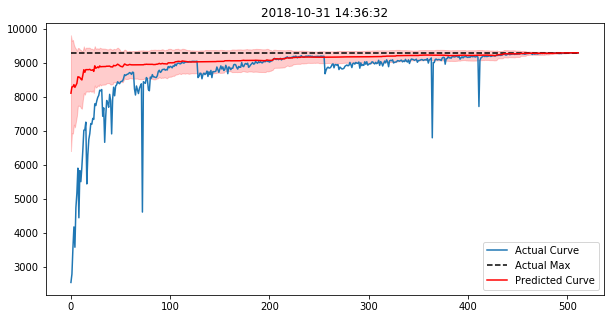

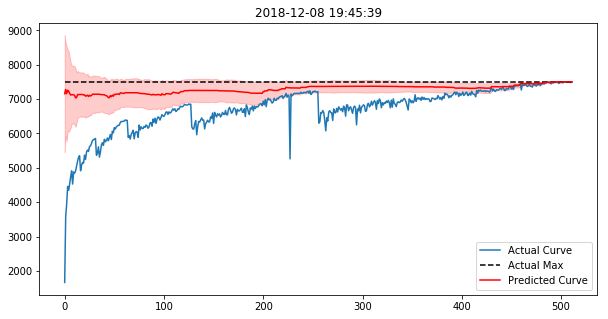

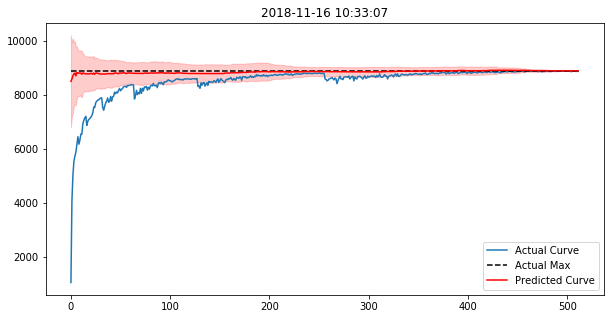

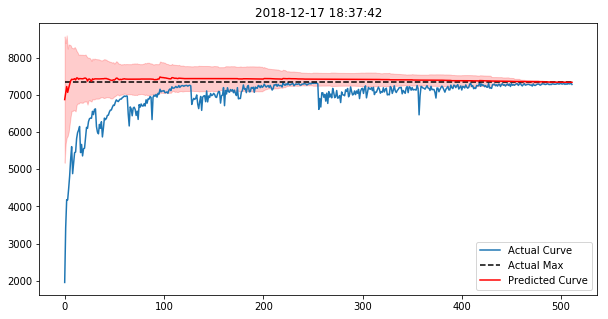

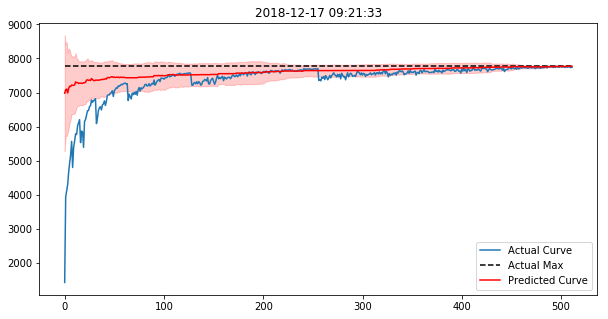

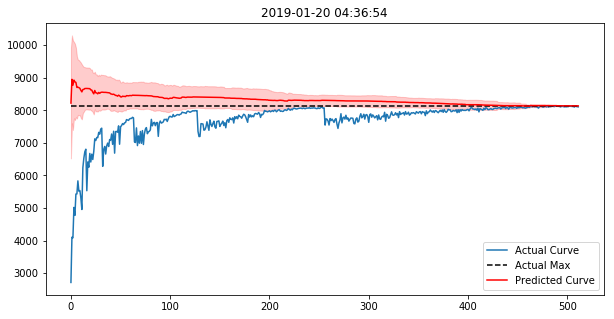

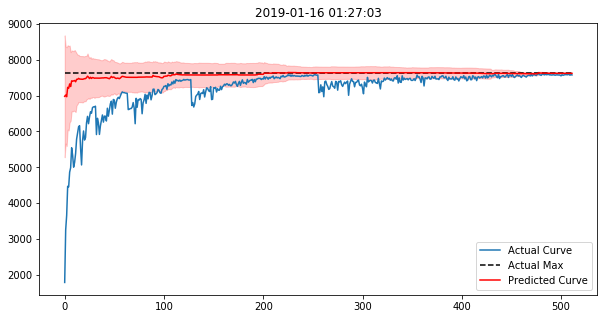

In [219]:
funcs = pkl.load(open('macro_loss_predictors.pkl',"rb"))
c95s = np.array([value['95'] for (key,value) in funcs.items()])

for idx,row in list(losses.sample(25).iterrows()):
#for idx,row in list(losses[-5:].iterrows()):
    plt.figure(figsize=(10,5))
    plt.plot(row['curve'],label='Actual Curve')
    preds = []
    for i in range(len(row['curve'])):
        X = row[['max_curve_{}'.format(i),'params','reductions','parallel','cells','nodes']]
        preds.append(funcs[i]['b']+np.dot(X,funcs[i]['m']))
    preds = np.array(preds)
    plt.fill_between(range(len(row['curve'])),preds+c95s,preds-c95s,color='red',alpha=.2)
    
    plt.plot([max(row['curve'])]*len(row['curve']),label="Actual Max",color='black',linestyle='dashed')
    plt.plot(preds,label="Predicted Curve",color='red')
    
    plt.title(row['run_date'])
    plt.legend(loc='lower right')
    plt.show()

# Micro Train Predictors

In [185]:
micro_losses               = copy.copy(run_stats)
micro_losses               = micro_losses[micro_losses['cell_types'].apply(lambda x: x==[1,1])]
micro_losses               = micro_losses[micro_losses['curve'].apply(lambda x: len(x)>=8)]
micro_losses['cell_matrices']   = micro_losses['cell_matrices'].apply(lambda x: x if len(x)<3 else [x])
micro_losses['reductions'] = micro_losses['cell_types'].apply(sum)
micro_losses['curve']      = micro_losses['curve'].apply(lambda x: x[:8] if len(x)>8 else x)
micro_losses['parallel']   = micro_losses['cell_matrices'].apply(len)
micro_losses['cells']      = micro_losses['cell_types'].apply(len)
micro_losses['nodes']      = micro_losses['cell_matrices'].apply(lambda x: len(x[0]) if len(x)<3 else len(x))

for i in range(8):
    if i==0:
        micro_losses['max_curve_{}'.format(i)]=micro_losses['curve'].apply(lambda x:x[0])
        micro_losses['max_increase_{}'.format(i)]=micro_losses['curve'].apply(lambda x: 1)
    else:
        micro_losses['max_curve_{}'.format(i)]=micro_losses['curve'].apply(lambda x: max(x[:i+1]))
        micro_losses['max_increase_{}'.format(i)]=micro_losses['max_curve_{}'.format(i)]-micro_losses['max_curve_{}'.format(0)]
        
micro_losses.to_pickle('micro_losses.pkl')
micro_losses.iloc[0:10]

,cell_matrices,cell_types,curve,data,drop_path,early_terminate,epoch,epochs,log,lr,lr_schedule,max,momentum,params,per_epoch_time,predictions,prefix,residual_cells,run_date,scale,scales,time_taken,track_progess,track_progress,verbose,weight_decay,reductions,parallel,cells,nodes,max_curve_0,max_increase_0,max_curve_1,max_increase_1,max_curve_2,max_increase_2,max_curve_3,max_increase_3,max_curve_4,max_increase_4,max_curve_5,max_increase_5,max_curve_6,max_increase_6,max_curve_7,max_increase_7
52,"[[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...","[1, 1]","[4482, 5538, 4659, 5930, 6327, 6035, 6970, 7195]",NaN,NaN,False,10,500.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",7195.0,0.9,61108.0,None,[],NaN,NaN,2018-10-31 14:18:34,2.0,"(2.0, 0.5)",None,NaN,NaN,True,0.0001,2,1,2,6,4482,1,5538,1056,5538,1056,5930,1448,6327,1845,6327,1845,6970,2488,7195,2713
57,"[[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...","[1, 1]","[4888, 5242, 6200, 6538, 6707, 7089, 6278, 7460]",NaN,True,False,10,10.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",7460.0,0.9,61108.0,None,[],NaN,NaN,2018-10-31 14:29:41,2.0,"(2.0, 0.5)","3 min, 29 s",NaN,NaN,True,0.0001,2,1,2,6,4888,1,5242,354,6200,1312,6538,1650,6707,1819,7089,2201,7089,2201,7460,2572
64,"[[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...","[1, 1]","[4629, 5455, 5651, 5207, 5188, 4589, 5942, 6620]",NaN,True,False,10,10.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",6620.0,0.9,68020.0,None,[],NaN,NaN,2018-11-01 15:11:10,2.0,"[(2.0, 0.5), (2.0, 0.5)]","8 min, 42 s",NaN,NaN,True,0.0001,2,2,2,6,4629,1,5455,826,5651,1022,5651,1022,5651,1022,5651,1022,5942,1313,6620,1991
82,"[[[0.0, 8.0, 0.0, 6.0, 4.0], [0.0, 0.0, 13.0, ...","[1, 1]","[4707, 4309, 5021, 5670, 5688, 6307, 6582, 6779]",NaN,True,False,10,10.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",7075.0,0.9,44926.0,None,[],NaN,NaN,2018-11-02 15:10:08,2.0,"[(2.0, 0.5)]","1 min, 49 s",NaN,NaN,True,0.0001,2,1,2,5,4707,1,4707,0,5021,314,5670,963,5688,981,6307,1600,6582,1875,6779,2072
92,"[[[0, 11, 11, 5, 11], [0, 0, 0, 0, 13], [0, 0,...","[1, 1]","[936, 4499, 4847, 4875, 5102, 5225, 5356, 5367]",NaN,True,False,10,10.0,True,NaN,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...",5434.0,0.9,22282.0,None,[],NaN,NaN,2018-11-05 14:19:52,2.0,"(2.0, 0.5)","1 min, 39 s",NaN,NaN,True,0.0001,2,1,2,5,936,1,4499,3563,4847,3911,4875,3939,5102,4166,5225,4289,5356,4420,5367,4431
93,"[[[0, 11, 11, 5, 11], [0, 0, 0, 0, 13], [0, 0,...","[1, 1]","[721, 4513, 4872, 5036, 5217, 5354, 5447, 5418]",NaN,True,True,9,10.0,True,NaN,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...",5481.0,0.9,22282.0,None,[],NaN,NaN,2018-11-05 14:23:06,2.0,"(2.0, 0.5)","1 min, 34 s",NaN,NaN,True,0.0001,2,1,2,5,721,1,4513,3792,4872,4151,5036,4315,5217,4496,5354,4633,5447,4726,5447,4726
94,"[[[0, 11, 11, 5, 11], [0, 0, 0, 0, 13], [0, 0,...","[1, 1]","[1063, 4403, 4942, 5101, 5321, 5409, 5421, 5560]",NaN,True,False,10,10.0,True,NaN,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...",5587.0,0.9,22282.0,None,[],NaN,NaN,2018-11-05 14:26:53,2.0,"(2.0, 0.5)","1 min, 36 s",NaN,NaN,True,0.0001,2,1,2,5,1063,1,4403,3340,4942,3879,5101,4038,5321,4258,5409,4346,5421,4358,5560,4497
95,"[[[0, 11, 11, 5, 11], [0, 0, 0, 0, 13], [0, 0,...","[1, 1]","[915, 4525, 4886, 5110, 5207, 5236, 5392, 5344]",NaN,True,False,10,10.0,True,NaN,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...",5459.0,0.9,22282.0,None,[],NaN,NaN,2018-11-05 14:28:50,2.0,"(2.0, 0.5)","1 min, 41 s",NaN,NaN,True,0.0001,2,1,2,5,915,1,4525,3610,4886,3971,5110,4195,5207,4292,5236,4321,5392,4477,5392,4477
96,"[[[0, 11, 11, 5, 11], [0, 0, 0, 0, 13], [0, 0,...","[1, 1]","[923, 4321, 4768, 5034, 5108, 5244, 5402, 5479]",NaN,True,False,10,10.0,True,NaN,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...",5556.0,0.9,22282.0,None,[],NaN,NaN,2018-11-05 14:32:20,2.0,"(2.0, 0.5)","1 min, 38 s",NaN,NaN,True,0.0001,2,1,2,5,923,1,4321,3398,4768,3845,5034,4111,5108,4185,5244,4321,5402,4479,5479,4556
97

In [186]:
def top_n(arr):
    return sorted(enumerate(arr),key=lambda x: x[1],reverse=True)

In [310]:
from scipy.stats import spearmanr
verbose = True

for delta in [True]:
    all_metrics = []
    all_funcs  = []
    for test_run in range(100):
        if 0:#:test_run==99:
            verbose=True
        else:
            verbose=False
        train,test = train_test_split(micro_losses,test_size=100/len(micro_losses))
        funcs = {}
        spearmans,pearsons,errors,top_25s = [],[],[],[]
        epoch_metrics = []
        for i in range(8):
            regr = linear_model.LinearRegression()

            if not delta:
                selector = ['max_curve_{}'.format(i),'params','reductions','parallel','cells','nodes']
            else:
                selector = ['max_curve_{}'.format(j) for j in range(0,i+1)]
                selector += ['params','reductions','parallel','cells','nodes']
            
            train_X = train[selector]
            train_Y = train['max']

            test_X = test[selector]
            test_Y = test['max']


            regr = linear_model.LinearRegression()
            regr.fit(train_X,train_Y)
            x_func = regr.intercept_+np.dot(train_X,regr.coef_)
            pred = regr.intercept_+np.dot(test_X,regr.coef_)
            c95 = np.std(test_Y.values-pred)*1.96
            funcs[i]={'b':regr.intercept_,'m':regr.coef_,'95':c95,'coef_names':selector}

            if verbose:
                print(selector)
                print("\n\n\n==Epoch {}==============================".format(i))
                print("Train/test sizes: {}, {}".format(len(train_X),len(test_X)))
                xy_df = pd.DataFrame(test_X*regr.coef_)
                xy_df['intercept']=regr.intercept_
                xy_df['pred']=xy_df.apply(lambda x: int(sum(x)),1)
                xy_df['_score']=test_Y
                xy_df['%pts error']=(xy_df['_score']-xy_df['pred'])/100
                #display(xy_df)
                test['%pts error']=xy_df['%pts error']
                test['pred']=xy_df['pred']
                if i==2:
                    displayer = test[test['%pts error'].apply(lambda x: np.abs(x)<.5 or np.abs(x)>3)]
                    #display(displayer.sort_values(by='%pts error'))

                plt.subplot(121)
                plt.plot(pred,test_Y,".")
                plt.plot(pred,pred,alpha=.5)
                plt.plot(pred,pred+c95,alpha=.5)
                plt.plot(pred,pred-c95,alpha=.5)
                plt.xlabel("Predicted Score")
                plt.ylabel("Actual Score")
                plt.title("Test")

                plt.subplot(122)
                plt.plot(x_func,train_Y,".")
                plt.plot(x_func,x_func,alpha=.5)
                plt.plot(x_func,x_func+c95,alpha=.5)
                plt.plot(x_func,x_func-c95,alpha=.5)
                plt.xlabel("Predicted Score")
                plt.ylabel("Actual Score")
                plt.title("Train")
                plt.tight_layout()

                plt.show()
                print('Intercept:', regr.intercept_)
                print('Coefficients: \n', *["{}: {:.4f}".format(list(train_X)[i],x) for (i,x) in enumerate(regr.coef_)])
            
            top_tests = top_n(test_Y.values)
            top_preds = top_n(pred)   
            top_test_set = set([x[0] for x in top_tests[:25]])
            top_pred_set = set([x[0] for x in top_preds[:25]])
            
            metrics = {}
            metrics["Pearson Correlation"]=pearsonr(x_func,train_Y)[0]
            metrics["Spearman Rank Correlation"]=spearmanr(pred,test_Y)[0]
            metrics["95% Confidence"]=c95                              
            metrics["Actual Top-5 in Pred Top-5"] = len([1 for test_val in top_tests[:5] if test_val[0] in [pred[0] for pred in top_preds[:5]]])/5.
            metrics["Actual Top-5 in Preds"] = len([1 for x in top_tests[:5] if x[0] in top_pred_set])/5.
            metrics["Actual Top-10 in Preds"] = len([1 for x in top_tests[:10] if x[0] in top_pred_set])/10.
            metrics["Actual Top-20 in Preds"]=len([1 for x in top_tests[:20] if x[0] in top_pred_set])/20.
            metrics["Actual Top-25 in Preds"]=len([1 for x in top_tests[:25] if x[0] in top_pred_set])/25.
            metrics["Actual Bottom-50 in Preds"]=len([1 for x in top_tests[50:] if x[0] in top_pred_set])/50.
            
            epoch_metrics.append(metrics)
            
            if verbose:
                for key, value in metrics.items():
                    print(key,":",value)
                
                plt.plot(range(len(top_tests)),range(len(top_tests)),alpha=.5)
                plt.plot(range(len(top_tests)),[[test[0] for test in top_tests].index(x[0]) for x in top_preds],".")
                plt.xlabel("Predicted Rank")
                plt.ylabel("Actual Rank")
                plt.show()
         
        all_funcs.append(funcs)
        all_metrics.append(epoch_metrics)
        
    summaries = [],[],[],[],[],[],[],[]
    for epoch_metrics in all_metrics:
        for i,epoch_metric in enumerate(epoch_metrics):
            summaries[i].append(epoch_metric)
    summary_dfs = [pd.DataFrame(x) for x in summaries]
    
    epoch_means = pd.DataFrame([summary_df.mean() for summary_df in summary_dfs])
    print(selector)
    display(epoch_means)
        

all_funcs.sort(key=lambda x: x[3]['95'])
pkl.dump(all_funcs[0],open('micro_loss_predictors.pkl',"wb"))



['max_curve_0', 'max_curve_1', 'max_curve_2', 'max_curve_3', 'max_curve_4', 'max_curve_5', 'max_curve_6', 'max_curve_7', 'params', 'reductions', 'parallel', 'cells', 'nodes']


,95% Confidence,Actual Bottom-50 in Preds,Actual Top-10 in Preds,Actual Top-20 in Preds,Actual Top-25 in Preds,Actual Top-5 in Pred Top-5,Actual Top-5 in Preds,Pearson Correlation,Spearman Rank Correlation
0,1117.617913,0.1940,0.510,0.4015,0.3684,0.482,0.652,0.420025,0.213199
1,617.659369,0.0620,0.770,0.6230,0.5888,0.586,0.882,0.864235,0.730876
2,443.016864,0.0180,0.824,0.7310,0.6792,0.640,0.934,0.931208,0.816764
3,307.687098,0.0074,0.918,0.8215,0.7640,0.662,0.956,0.966305,0.890595
4,242.405248,0.0002,0.942,0.8550,0.7968,0.696,0.992,0.979337,0.922933
5,174.247199,0.0002,0.962,0.8790,0.8216,0.758,0.990,0.989805,0.951373
6,115.887965,0.0000,0.991,0.9365,0.8800,0.796,1.000,0.995644,0.974908
7,35.551857,0.0000,1.000,1.0000,0.9892,0.982,1.000,0.999600,0.997808


# Check Micro Predictions

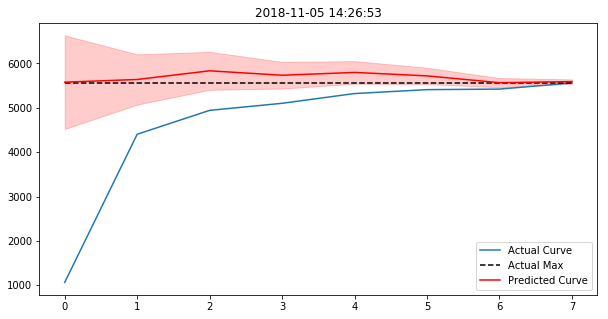

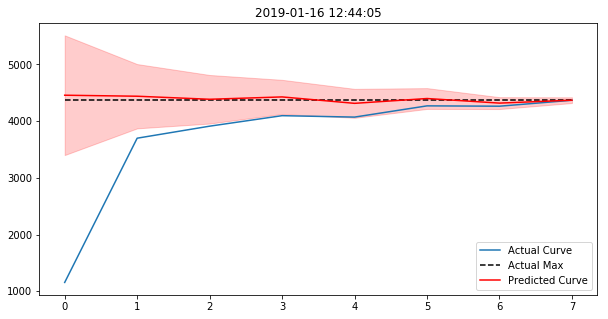

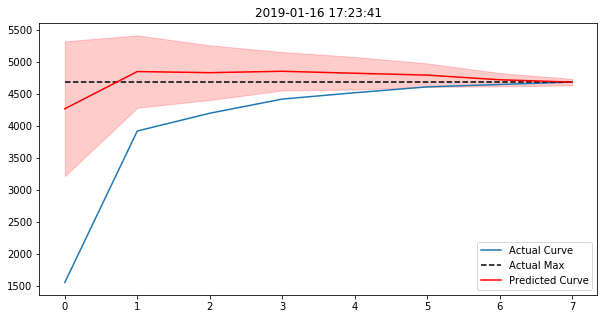

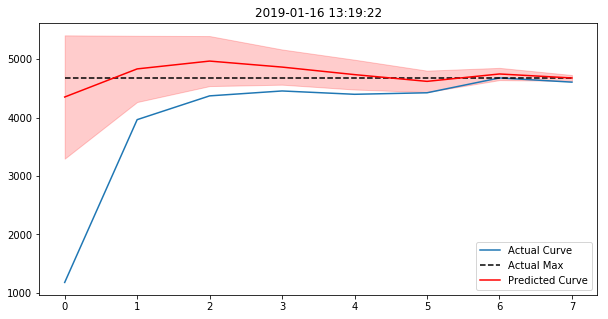

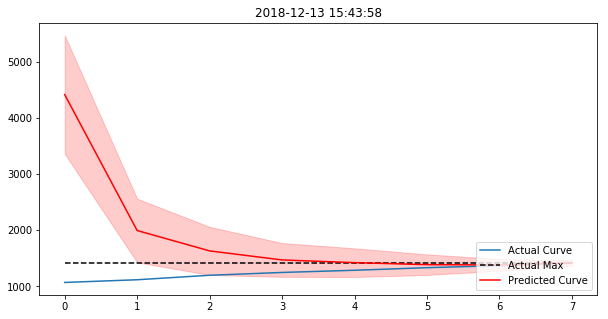

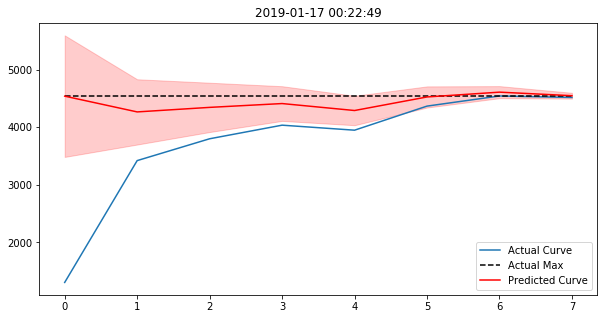

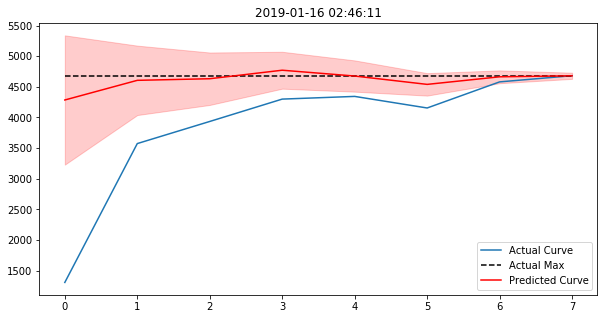

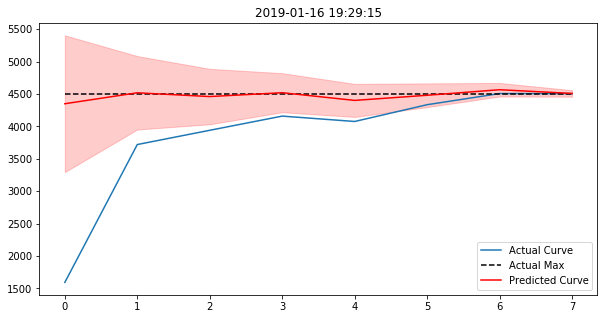

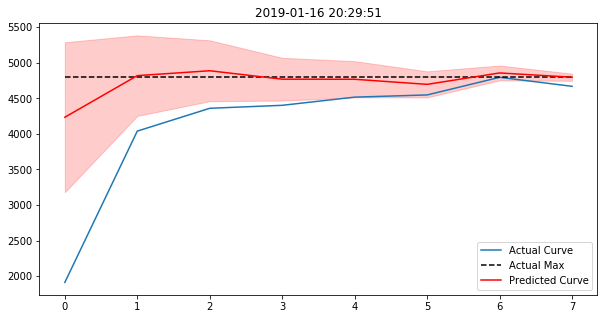

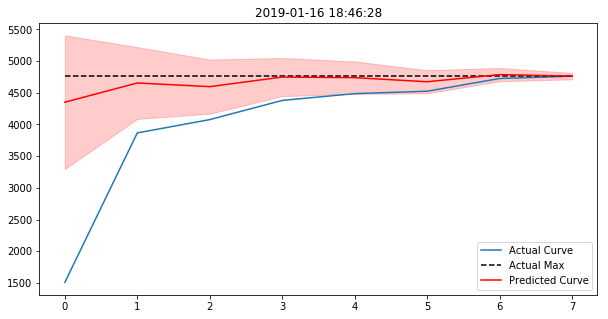

In [191]:
funcs = pkl.load(open('micro_loss_predictors.pkl',"rb"))
c95s = np.array([value['95'] for (key,value) in funcs.items()])

for idx,row in list(micro_losses.sample(10).iterrows()):
    plt.figure(figsize=(10,5))
    plt.plot(row['curve'],label='Actual Curve')
    preds = []
    for i in range(len(row['curve'])):
        X = row[['max_curve_{}'.format(i),'params','reductions','parallel','cells','nodes']]
        preds.append(funcs[i]['b']+np.dot(X,funcs[i]['m']))
    preds = np.array(preds)
    plt.fill_between(range(len(row['curve'])),preds+c95s,preds-c95s,color='red',alpha=.2)
    
    plt.plot([max(row['curve'])]*len(row['curve']),label="Actual Max",color='black',linestyle='dashed')
    plt.plot(preds,label="Predicted Curve",color='red')
    
    plt.title(row['run_date'])
    plt.legend(loc='lower right')
    plt.show()

# See Micro/Macro Correlation

In [23]:
matrices = {}

for idx,row in run_stats.iterrows():
    if not type(row['cell_matrices'])==float:
        if len(row['cell_matrices'])>1:
            cell_matrix = np.array(row['cell_matrices'][0])
        else:
            cell_matrix = np.array(row['cell_matrices'])

        if matrices.get(cell_matrix.tobytes()) is None:
            matrices[cell_matrix.tobytes()] = []
        matrices[cell_matrix.tobytes()].append(row)
matrix_dfs = [pd.DataFrame(matrices[x]) for x in matrices.keys()]

display(matrix_dfs[-5])

,cell_matrices,cell_types,curve,data,drop_path,early_terminate,epoch,epochs,log,lr,lr_schedule,max,momentum,params,per_epoch_time,predictions,prefix,residual_cells,run_date,scale,scales,time_taken,track_progess,track_progress,verbose,weight_decay
1100,"[[[0.0, 5.0, 1.0, 11.0, 0.0, 0.0, 10.0], [1.0,...","[1, 1]","[989, 3916, 4128, 4244, 4170, 4355, 4496, 4576]",NaN,False,False,8,8.0,True,0.01,"{'type': 'cosine', 'lr_min': 1e-05, 'lr_max': ...",4576.0,0.9,5964.0,8.84 s,"[4347.0, 4833.0, 4755.0, 4666.0, 4522.0, 4523....",Micro,NaN,2019-01-17 10:27:23,2.0,"(2.0, 0.5)","1 min, 19 s",NaN,True,False,0.0001
1101,"[[[0.0, 5.0, 1.0, 11.0, 0.0, 0.0, 10.0], [1.0,...","[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]","[1939, 3503, 4478, 5117, 4891, 5065, 5595, 577...",NaN,True,False,512,512.0,True,0.01,"{'type': 'cosine', 'lr_min': 1e-05, 'lr_max': ...",7473.0,0.9,1864586.0,57.87 s,"[6862.0, 7789.0, 8195.0, 8532.0, 8738.0, 8180....",Macro,NaN,2019-01-17 19:03:42,5.0,"(2.0, 0.5)","8 hrs, 36 mins, 18 s",NaN,True,False,0.0001


In [104]:
pairs = []
matrix_id=0

for matrix_df in matrix_dfs:
    micro_scores,macro_scores = [],[]
    micro_stats,macro_stats = [],[]
    micro,macro=False,False
    
    cell_counts = []
    for idx,row in matrix_df.iterrows():
        if len(row['cell_types'])==2 and len(row['curve'])>=8:
            micro_scores.append(row['curve'][-1])
            micro_stats.append(dict(("micro_"+k,v) for (k,v) in row.items()))
            micro=True
        elif sum(row['cell_types'])==5 and len(row['curve'])==512:
            macro_scores.append(max(row['curve']))
            macro_stats.append(dict(("macro_"+k,v) for (k,v) in row.items()))
            macro=True
    if micro and macro:
        matrix_id+=1
    
    for i,micro in enumerate(micro_scores):
        for j,macro in enumerate(macro_scores):
            pair_dict = {"_score_micro":micro,"_score_macro":macro,"_matrix_id":matrix_id}
            pair_dict.update(micro_stats[i])
            pair_dict.update(macro_stats[j])
            pairs.append(pair_dict)
            
pair_df = pd.DataFrame(pairs)
pair_df['micro_reductions']=pair_df['micro_cell_types'].apply(sum)
pair_df['macro_reductions']=pair_df['macro_cell_types'].apply(sum)
pair_df['micro_cells']=pair_df['micro_cell_types'].apply(len)
pair_df['macro_cells']=pair_df['macro_cell_types'].apply(len)
pair_df['nodes']=pair_df['macro_cell_matrices'].apply(lambda x: len(x[0]))
pair_df['micro_delta']=pair_df['micro_curve'].apply(lambda x: max(x)-x[0])
pair_df['macro_cell_parallel']=pair_df['macro_cell_matrices'].apply(len)
pair_df.to_pickle('pair_losses.pkl')

pair_df

,_matrix_id,_score_macro,_score_micro,macro_cell_matrices,macro_cell_types,macro_curve,macro_data,macro_drop_path,macro_early_terminate,macro_epoch,macro_epochs,macro_log,macro_lr,macro_lr_schedule,macro_max,macro_momentum,macro_params,macro_per_epoch_time,macro_predictions,macro_prefix,macro_residual_cells,macro_run_date,macro_scale,macro_scales,macro_time_taken,macro_track_progess,macro_track_progress,macro_verbose,macro_weight_decay,micro_cell_matrices,micro_cell_types,micro_curve,micro_data,micro_drop_path,micro_early_terminate,micro_epoch,micro_epochs,micro_log,micro_lr,micro_lr_schedule,micro_max,micro_momentum,micro_params,micro_per_epoch_time,micro_predictions,micro_prefix,micro_residual_cells,micro_run_date,micro_scale,micro_scales,micro_time_taken,micro_track_progess,micro_track_progress,micro_verbose,micro_weight_decay,micro_reductions,macro_reductions,micro_cells,macro_cells,nodes,micro_delta,macro_cell_parallel
0,1,9096,4929,"[[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...","[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]","[1008, 1662, 2794, 3015, 3565, 3811, 4380, 465...",NaN,True,False,512,512.0,True,NaN,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...",9096.0,0.9,15816838.0,"1 min, 24 s",[],NaN,False,2018-11-15 02:30:05,3.0,"(2.0, 0.5)","12 hrs, 39 mins, 35 s",NaN,NaN,True,0.0001,"[[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...","[1, 1]","[4629, 5455, 5651, 5207, 5188, 4589, 5942, 662...",NaN,True,False,10,10.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",6620.0,0.9,68020.0,None,[],NaN,NaN,2018-11-01 15:11:10,2.0,"[(2.0, 0.5), (2.0, 0.5)]","8 min, 42 s",NaN,NaN,True,0.0001,2,5,2,13,6,1991,1
1,1,8886,4929,"[[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...","[1, 0, 1, 0, 1, 0, 1, 0, 1]","[1065, 4079, 5030, 5537, 5732, 5880, 6162, 644...",NaN,True,False,512,512.0,True,NaN,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...",8886.0,0.9,26385610.0,"2 min, 12 s",[],NaN,False,2018-11-16 10:33:07,3.0,"(2.0, 0.5)","19 hrs, 49 mins, 50 s",NaN,NaN,True,0.0001,"[[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...","[1, 1]","[4629, 5455, 5651, 5207, 5188, 4589, 5942, 662...",NaN,True,False,10,10.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",6620.0,0.9,68020.0,None,[],NaN,NaN,2018-11-01 15:11:10,2.0,"[(2.0, 0.5), (2.0, 0.5)]","8 min, 42 s",NaN,NaN,True,0.0001,2,5,2,9,6,1991,2
2,1,8867,4929,"[[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...","[1, 0, 1, 0, 1, 0, 1, 0, 1]","[854, 3979, 4933, 5318, 5248, 5777, 6158, 6311...",NaN,True,False,512,512.0,True,NaN,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...",8867.0,0.9,13244098.0,"1 min, 7 s",[],NaN,False,2018-11-20 07:56:03,3.0,"(2.0, 0.5)","10 hrs, 6 mins, 58 s",NaN,NaN,True,0.0001,"[[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...","[1, 1]","[4629, 5455, 5651, 5207, 5188, 4589, 5942, 662...",NaN,True,False,10,10.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",6620.0,0.9,68020.0,None,[],NaN,NaN,2018-11-01 15:11:10,2.0,"[(2.0, 0.5), (2.0, 0.5)]","8 min, 42 s",NaN,NaN,True,0.0001,2,5,2,9,6,1991,1
3,1,8551,4929,"[[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...","[1, 0, 1, 0, 1, 0, 1, 0, 1]","[953, 4165, 4769, 5170, 5274, 5571, 5704, 5870...",NaN,True,False,512,512.0,True,NaN,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.00...",8551.0,0.9,14700034.0,"1 min, 28 s",[],NaN,False,2018-11-21 00:26:34,3.0,"(2.0, 0.5)","13 hrs, 17 mins, 7 s",NaN,NaN,True,0.0001,"[[[0, 9, 9, 15, 2, 0], [0, 0, 14, 0, 13, 5], [...","[1, 1]","[4629, 5455, 5651, 5207, 5188, 4589, 5942, 662...",NaN,True,False,10,10.0,True,0.01,"{'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01...",6620.0,0.9,68020.0,None,[],NaN,NaN,2018-11-01 15:11:10,2.0,"[(2.0, 0.5), (2.0, 0.5)]","8 min, 42 s",NaN,NaN,True,0.0001,2,5,2,9,6,1991,2
4,2,6940,4753,"[[[0, 11, 11, 5, 11], [1, 0, 0, 0, 13], [1, 0,...","[1, 0, 1, 0, 1, 0, 1, 0, 1]","[1259, 3359, 3715, 4218, 4223, 4217, 4500, 472...",NaN,True,False,512,512.0,True,0.01,"{'type': 'cosine', 'lr_min': 1e-05, 'lr_max': ...",6940.0,0.9,217946.0,3

Train/Test: 18 6
Intercept: 3556.6628804252696
Coefficients: 
 _score_micro: 0.6871 macro_cells: 80.9053 micro_params: 0.0201 macro_cell_parallel: -265.5341 nodes: 7.4588


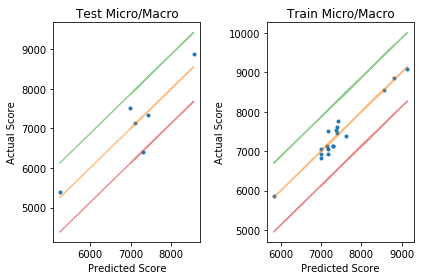

Pearson:  0.97,p=1.0689962277911549e-11
Spearman: 0.91,p=2.075612283591499e-07
95%: ±870.60
Pearsons: 0.962707668385158
Error: 609.3471007691542


In [220]:
from sklearn import linear_model
import copy
verbose = False

errors = []
pearsons = []
for test_run in range(100):
    selector = ['_score_micro','macro_cells','micro_params','macro_cell_parallel','nodes']
    pair_df['micro_delta']=pair_df['micro_curve'].apply(lambda x: x[-1])-pair_df['micro_curve'].apply(lambda x: x[0])

    train,test = train_test_split(pair_df,test_size=.25)     
    train_X,test_X = train[selector],test[selector]
    train_Y,test_Y = train['_score_macro'],test['_score_macro']

    regr = linear_model.LinearRegression()
    regr.fit(train_X,train_Y)
    
    x_func = regr.intercept_+np.dot(train_X,regr.coef_)
    pred   = regr.intercept_+np.dot(test_X,regr.coef_)
    c95  = np.std(test_Y.values-pred)*1.96
    func ={'b':regr.intercept_,'m':regr.coef_,'95':c95,'coef_names':selector}
    pearson = pearsonr(x_func,train_Y)
    
    pearsons.append(pearson[0])
    errors.append(c95)
    
    if verbose or test_run==99:
        print("Train/Test:",len(train),len(test))
        print('Intercept:', regr.intercept_)
        print('Coefficients: \n', *["{}: {:.4f}".format(list(train_X)[i],x) for (i,x) in enumerate(regr.coef_)])
        plt.subplot(121)
        plt.plot(pred,test_Y,".")
        plt.plot(pred,pred,alpha=.5)
        plt.plot(pred,pred+c95,alpha=.5)
        plt.plot(pred,pred-c95,alpha=.5)
        plt.xlabel("Predicted Score")
        plt.ylabel("Actual Score")
        plt.title("Test Micro/Macro")

        plt.subplot(122)
        plt.plot(x_func,train_Y,".")
        plt.plot(x_func,x_func,alpha=.5)
        plt.plot(x_func,x_func+c95,alpha=.5)
        plt.plot(x_func,x_func-c95,alpha=.5)
        plt.xlabel("Predicted Score")
        plt.ylabel("Actual Score")
        plt.title("Train Micro/Macro")
        plt.tight_layout()

        plt.show()

        print("Pearson:  {:.2f},p={}".format(*pearson))
        print("Spearman: {:.2f},p={}".format(*spearmanr(x_func,train_Y)))
        print("95%: ±{:.2f}".format(c95))

print("Pearsons:",np.mean(pearsons))
print("Error:",np.median(errors))
pkl.dump(func,open('pair_predictors.pkl',"wb"))